# 강화학습 실습

- 다중 슬롯 머신
  - 가치 계산용 알고리즘
    - UCB1
    - ε-greedy
  - 강화학습 입문형

- 미로게임
  - 정책 계산 (정책반복법, 가치계산법)
    - 알고리즘
      - 정책경사법
      - Sarsa
      - Q-Learning
- 카트풀 게임
  - openAI-gym 제공 받아서 활용
    - 정책 계산(정책반복법, 가치계산법)
      - 알고리즘
        - DQN 활용(tensorflow + keras)

# 다중 슬롯머신

- 목적
  - 강화학습, 스타일을 익힌다
  - 강화학습의 절차 습득 및 요소 정의, 학습 스타일 습득

- 환경
  - 게임의 룰
  - 슬롯머신의 ARM(팔)이 여러개 존재할 수 있다(현실세계에서 슬롯머신은 통상 ARM이 한개이다)
  - 각각의 ARM은 보상치가 다르다. 각각의 확률이 정해져 있다
    - 1번 ARM 10% 확률로 보상제공 
    - 2번 ARM 50% 확률로 보상제공
    - 각각의 보상치는 동일하게 1이다
  - 에이전트는 게임을 시작하면 각 팔에 대해서는 보상 확률을 모른다. 게임이 세팅되면 확률은 정해진다
    - 보상의 크기는 중요하지 않다(1), 보상을 받는가 OR 못받는가에만 집중

- 에이전트의 목적
  - 어떤 ARM을 선택해야 최대 보상을 받는가? 이 ARM을 찾아내는 것이 관건 -> 이것이 학습의 목적
- 에이전트의 행동
  - 여러개의 ARM 중 한개를 선택(당긴다)
  - ARM의 확률에 따라 보상을 지급(0 OR 1)
  - 게임 한 판이 종료된다

|강화 학습 요소|다중 슬롯 머신 게임|
|--:|:--|
|에이전트|슬롯 머신을 내리는 사람|
|환경|다중 슬롯 머신|
|목적|많은 보상 획득, 제한된 횟수|
|행동|여러 개의 ARM중 한개를 선택(당긴다)|
|에피소드|ARM을 당기면, 게임 종료|
|상태|없음|
|보상|1.0 혹은 0.0|
|수익|보상의 총합(즉시보상 + 지연보상(0))|
|학습방법|UCB1, ε-greedy|
|파라미터갱신주기|1회 행동으로 게임 종료되면 즉시 진행|
|정책|다음 슬롯머신 ARM 선택시 판단용|

# 정책

- **탐색과 이용의 트레이드 오프 문제**
  - 정보수집을 위해서 탐색을 수행하면, 언젠가 모든 ARM에 대한 정보를 알게 된다. 만약 제한된 횟수에서 탐색의 수가 늘어나면, 가장 높은 팔만 집중적으로 당기는 수익보다는 적을 것이다

  - 반대 관점, 몇 번 선택 후, 가장 높은 보상을 받은 ARM을 집중적으로 선택한다면 => 나중에 더 높은 보상을 주는 ARM을 선택하지 못해서 더 적은 보상을 받을 수도 있다

# 구현

## 구조

```
- SlotMachineGame
  L SlotArm Class : 슬롯머신의 팔
  L GameEngine Class : 알고리즘 사용의 표준 인터페이스 제공
    L EpsilonGreedyEngine Class : 알고리즘 1
    L UCB1Engine Class : 알고리즘 2
  L GameSimulator Class or function : 게임 가동, 시뮬레이션 진행 
```

# 필요 모듈

In [1]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# SlotArm Class

In [2]:
m = [random.random() for n in range(1000)]
print(m)

[0.8028129532552715, 0.5855839934140197, 0.7790493434679294, 0.3019337416650757, 0.6061265755570459, 0.08757228270128359, 0.16154676221077358, 0.8235228688604814, 0.5790304008184111, 0.040744228152607476, 0.3268231222818726, 0.7038070297484229, 0.3209437020064516, 0.6674861052037246, 0.3768426066577143, 0.781477713965956, 0.9329238468156053, 0.4659644795164306, 0.2906226873759151, 0.9524818380630303, 0.5781471770166619, 0.7086705844542494, 0.3360801672160074, 0.7391070280107986, 0.1801488719483988, 0.11154411277039644, 0.9836231800403935, 0.2992100692761541, 0.5776784553980515, 0.9075741328387851, 0.7553904181020064, 0.96141291167796, 0.25740232858741485, 0.3996440899985878, 0.31998861298967685, 0.21679105716792535, 0.5148879970277537, 0.4983215506864096, 0.7203272871416204, 0.827457827763855, 0.7349601762043094, 0.8667487392987036, 0.3182098017367063, 0.80505350307353, 0.19474831324228148, 0.5310394023472219, 0.3033659259594228, 0.6454350197440437, 0.2106604531509081, 0.67651676316941

In [3]:
# 다중 슬롯 머신의 ARM을 구현, 모든 ARM은 같은 형태를 취한다
# ARM은 보상을 주는 확률을 각각 고유하게 가지고 있다
class SlotArm:
  # 멤버변수를 사용하기 전에 반드시 멤버변수가 생성 혹은 초기화 되어야 한다
  p = None
  # 생성자 -> 객체를 생성할때 호출, 이름은 고정 ( __init__ )
  # 생성자 재정의(override)
  def __init__( self, p ):
    # 멤버변수를 생성자 내부에서 생성 한것이다
    self.p = p
    #pass
  
  # 멤버함수
  def reward2( self ):
    return 1.0 if self.p > random.random() else 0.0
    #return self.p > random.random() and 1.0 or 0.0 # 조건에 따라 안될 수 있으므로 가급적 배제
    #pass
  def reward( self ):
    # 특정 확률 이하로 랜덤값이 나오면 보상 지급 => ~ if ~ else  /  ~ and ~ or ~
    # 조건이 2개, 값을 리턴하는 스타일=> 삼항연산자 방식(공식적으로는 파이썬에는 없음) 사용가능
    # 변수 = 참일때값 if 조건 else 거짓일때값
    # 변수 = 조건 and 참일때값 or 거짓일때값
    # random.random() => 이 값의 정규분포가 적절한가? (여기서는 미고려)
    if self.p > random.random():
      return 1.0
    else:
      return 0.0
    #pass
  #pass

# 확률 50% 로 보상을 주는 ARM 을 만들어라
SlotArm( 0.5 )
SlotArm( 0.1 )
sa = SlotArm( 0.3 )

In [4]:
class SlotArm:
  '''
  __init__(self.p), p는 확률(0.0 <= x <= 1.0)
  reward(self)는 p 확률 이하로 보상을 지급(1.0), 미지급(0.0)
  '''
  def __init__( self, p ):
    self.p = p

  def reward( self ):
    if self.p > random.random():
      return 1.0
    else:
      return 0.0


# GameEngine

- 객체 지향 프로그램의 상속성을 활용하여, 2개의 알고리즘을 동일한 인터페이스 형태로 구현하려고 한다
- 테스트 코드는 for문에서 동일한 함수를 호츌하는것으로 비교할 수 있다

In [5]:
class GameEngine() :
  # 알고리즘 초기화
  def initialize(self) : pass
  # 팔을 당긴다
  def pull_arm(self) : pass
  # 보상 업데이트
  def update_value(self) : pass 
  # 알고리즘 정보
  def get_engine_info(self) : pass

## EpsilonGreedyEngine

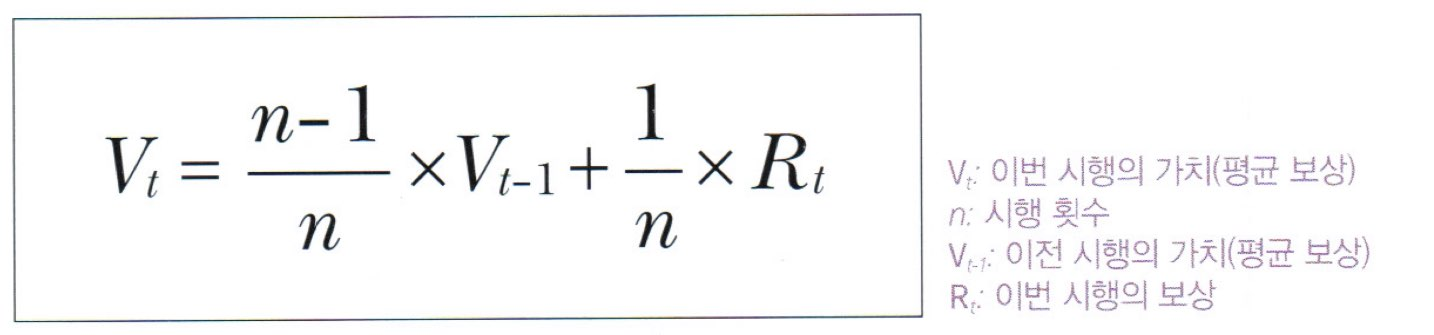

In [6]:
from IPython.display import Image
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/ε-greedy.jpeg')
# 가치를 계산하는 식
# 현재시점의행동의가치 = (처음부터 직전까지 시도한 횟수 / 전체 시행횟수) * 이전행동까지의 가치 +
#                        (1 / 전체시행횟수) * (이번 행동으로 얻는 보상)

- EpsilonGreedyEngine 알고리즘(ε-greedy)
  - 확률 ε로 랜덤하게 행동을 선택한다
    - ε(0~1) or 1-ε 를 기준으로 랜덤하게 행동을 선택
    - 에이전트가 ARM을 선택하는 행위
  - 통상적으로 0,1을 사용할 경우 가장 높은 성능을 낸다
  - 탐색과 이용에 대한 상충관계 처리를 해야한다
    - 균형
    - 탐색 : ε로 배치
    - 이용 : 1- ε로 배치
    - 어떤 ARM을 선택하는가?

In [7]:
class EpsilonGreedyEngine(GameEngine) :
  '''
    ε-greedy를 이용한 ARM 선택 엔진
    epsilon 값은 기본값 0.1을 사용
  '''
  def __init__(self, _epsilon = 0.1) : # 생성자
    self.epsilon = _epsilon
    pass
  def initialize(self, count_arms) :   # 알고리즘 초기화
  # 멤버가 모두 0인 배열을 생성
  # 특정 ARM이 몇번 선택되었는지를 기록하는 배열이다
  # self.n의 총합은 ARM을 선택한 총 횟수, 총 에피소드의 합, 전체 플레이 횟수
    self.n = np.zeros(count_arms)
  # 각 ARM에 대한 보상값 기록
    self.v = np.zeros(count_arms)

  def pull_arm(self) : # 팔을 당긴다
    if self.epsilon > random.random() : # ex) 10% 확률 -> 탐색
      return np.random.randint(0, len(self.n)) # 0 or 1 or 2 or 3
    else : # ex) 90% 확률 -> 이용 -> 각 팔들 중에서 보상값이 가장 높은 ARM
      return np.argmax(self.v)
  # 보상 업데이트 -> 특정 ARM에 대해 가치 업데이트, 선택횟수 증가
  # 시뮬레이션 진행 => arm 선택 => 보상이 리턴 => 이 정보를 넣어서 아래 함수 호출
  # arm 1번 10회, arm 2번 20회, ....
  # 각 arm별로 가치는 달라진다 가치 계산도 arm별로 진행
  def update_value(self, choice_arm, reward) :
    # 1. 특정 arm 선택 횟수 증가 
    self.n[choice_arm] += 1
    # 2. 특정 arm의 가치 계산
    n = self.n[choice_arm]
    v = self.v[choice_arm]
    self.v[choice_arm] = ((n-1) / n) * v + (1 / n) * (reward)
    pass 
  
  def get_engine_info(self) : # 알고리즘 정보
    return 'ε-greedy를 이용한 ARM 선택 엔진'
    pass 

EpsilonGreedyEngine()
EpsilonGreedyEngine(0.2)
EpsilonGreedyEngine(_epsilon = 0.3)

In [8]:
# 구성원이 4개인 1차원 배열 생성, 기본값은 0
np.zeros(4)

array([0., 0., 0., 0.])

In [9]:
tmp = np.array([ 1,2,3,4])
tmp

array([1, 2, 3, 4])

In [10]:
# tmp에서 가장 큰값(보상, VALUE)을 가진 위치값(인덱스)
# 구성원들 중에서 가장 높은 값을 가진 구성원의 인덱스를 리턴
np.argmax(tmp)

3

## UCB1Engine

- 원리
  - 모든 팔을 한번씩 혹은 한 번 이상 사용할 때까지 가치 계산 갱신을 하지 않는다 => 전체 ARM 탐색
  - 만약, 모든 arm이 1회 이상 선택되었다면, arm의 가치 갱신 시작한다

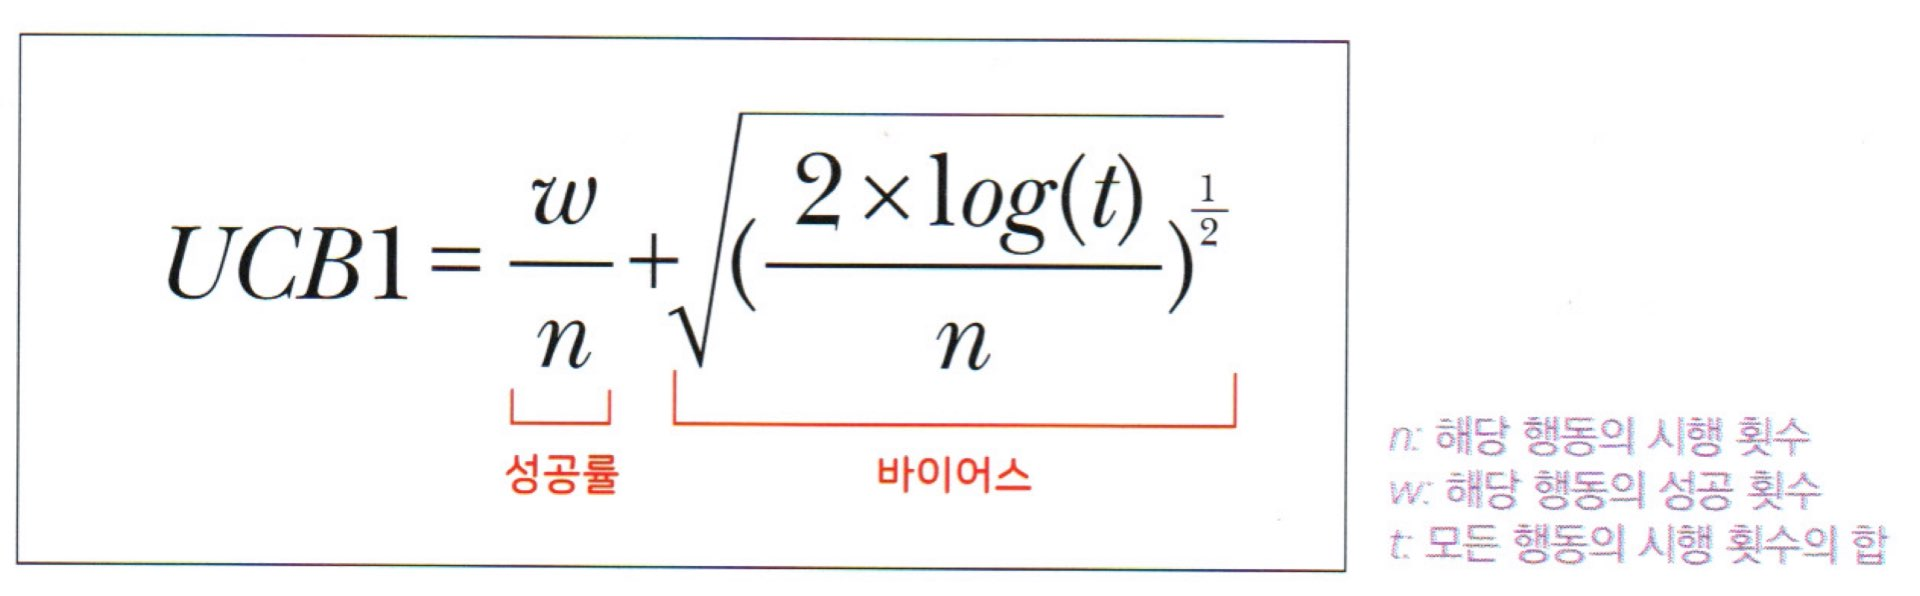

In [11]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/UCB1.jpeg')
# 제곱만 보거나 1/2 제곱만 살펴본다 (그림 오류)
# 성공률 + 바이어스(bais, 평행값, 미세조정)
# ARM을 하나 선택하면 모든 ARM의 가치를 재조정한다(t값 때문에)

In [12]:
# UCB1Engine 기본틀 작업 구현
class UCB1Engine(GameEngine) :
  # 알고리즘 초기화
  def initialize(self, count_arms) :
    # 각 ARM의 실행횟수
    self.n = np.zeros(count_arms)
    self.v = np.zeros(count_arms)
    # 각 ARM의 보상을 받은 횟수를 담은 배열 
    self.w = np.zeros(count_arms)   
    pass
  # 팔을 당긴다 => 어떤 arm을 당길것인가 => arm의 인덱스를 리턴
  def pull_arm(self) :
    # 모든 ARM을 당길때까지 -> 계속 탐색 => 미선택 ARM이 있으면 리턴
    for i in range(len(self.n)) :
      # 한번도 선택되지 않은 ARM
      if not self.n[i] :
        return i
    # 만약 모든 ARM이 선택 되었다면 -> 이용 => 가치가 가장 높은 ARM 선택
    return np.argmax(self.v)   
    pass
  # 보상 업데이트
  def update_value(self, choice_arm, reward) :
    self.n[choice_arm] += 1
    # 보상을 받은 횟수 증가
    if reward :
      self.w[choice_arm] += 1
      # 3. 모든 arm이 최소 1번씩은 선택되었는가
      for i in range(len(self.n)) :
      # 한번도 선택되지 않은 ARM
        if not self.n[i] :
          return # 아직 선택 안한 ARM이 있다 -> 가치 계산 안함
      # 4. 가치 계산 => 가치 갱신 => 모든 ARM을 계산
      for i in range(len(self.n)) :
        # 성공률 => win
        suc_rate = self.n[i] / self.n[i]
        # 편향, 바이어스 => (2 * log(t) / n)^1/2
        t = self.n.sum() # 모든 ARM들 계산
        bais =  (2 * math.log(t) / self.n[i])**0.5
        self.v[choice_arm] = suc_rate + bais

    pass
  # 알고리즘 정보
  def get_engine_info(self) :    
    return 'UCB1을 이용한 ARM 선택 엔진'
    pass
  
UCB1Engine()

# 시뮬레이션

In [13]:
def play(engine, slot_arms, sim_cnt, epi_cnt) :
  #  총 시도횟수
  times = np.zeros(sim_cnt * epi_cnt)
  # 보상
  rewards = np.zeros(sim_cnt * epi_cnt)
  #  시뮬레이션 진행
  for sidx in range(sim_cnt) :     # 0 ~ sim_cnt - 1
     # 게임 엔진 초기화 -> 250회 ARM 선택 -> 종료 -> 총 1000번 수행
     # arm의 총 개수를 넣어서 엔진 초기화
     engine.initialize(len(slot_arms)) 
     for step in range(epi_cnt) :
       # 0. 시도 횟수를 기록한다  => times => [1,2,3,...,250,1,2,3...,250,1,2,....250]
       offset = epi_cnt * sidx
       index = offset + step
       times[offset] = step + 1
       # 1. ARM을 당긴다
       cur_arm_index = engine.pull_arm()
       # 2. 가치를 계산한다
       reward = slot_arms[cur_arm_index].reward()
       # 3. 계산된 가치를 저장한다 -> rewards
       rewards[index] = reward
       # 4. 가치 업데이트
       engine.update_value(cur_arm_index, reward)
       pass
     pass



  return times, rewards
  pass

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53469 missing from current font.
  font.set_

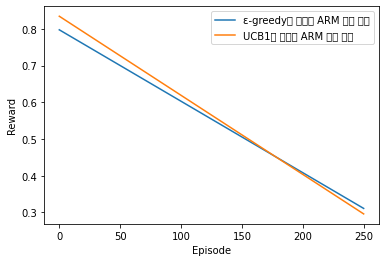

In [14]:
# 전체 시뮬레이션 횟수
SIMULATION_COUNT = 1000
# 에피소드 횟수 (시뮬레이션 1회당 250회 )
EPISODE_COUNT    = 250

# 게임 구성
slot_arms = [
  SlotArm(0.3),             
  SlotArm(0.5),
  SlotArm(0.9),
]
engines    = [
  EpsilonGreedyEngine(),
  UCB1Engine()
]

# 시뮬레이션 진행
for engine in engines:
  # 1. 시뮬레이션 
  times, rewards = play( engine, slot_arms, SIMULATION_COUNT, EPISODE_COUNT )
  # 2. 결과를 가지고 시각화 -> 모니터링 (X축 시도횟수, y축을 보상)
  df = pd.DataFrame( {
      'times':times,
      'rewards':rewards
  } )
  # 3. times(1~250)를 그룹화하여 평균으로  조정하여 시각화
  tmp = df.groupby( 'times' ).mean()
  # 4. 시각화
  plt.plot( tmp, label = engine.get_engine_info() )

# 데코
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# 출력
plt.show()